## Comparing random sampling of text corpus to original after LDA

In [13]:
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn dataset
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data

# convert to bag of words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(documents)
vocab = np.array(vectorizer.get_feature_names_out())

In [14]:
# bootstrapping code
def resample_documents(word_counts, depth=100):
    new_docs = []
    for doc_idx in range(word_counts.shape[0]):
        word_indices = word_counts[doc_idx].nonzero()[1]  # nonzero words in the doc

        if len(word_indices) == 0:  # skip empty documents
            new_docs.append("")
            continue

        word_frequencies = word_counts[doc_idx].toarray().flatten()[word_indices]  # frequencies
        
        # create a probability distribution
        probabilities = word_frequencies / word_frequencies.sum()
        
        # sample `depth` words with replacement
        sampled_indices = np.random.choice(word_indices, size=depth, p=probabilities)
        
        # Reconstruct text document
        new_doc = ' '.join(vocab[sampled_indices])
        new_docs.append(new_doc)
    
    return new_docs

In [15]:
# run LDA on the original dataset
num_topics = 10
lda_original = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_original.fit(word_counts)
original_topic_distributions = lda_original.components_ / lda_original.components_.sum(axis=1, keepdims=True)

# display the top words for each topic
vocab = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(lda.components_):
    top_words = vocab[np.argsort(topic)[-10:]]  # Top 10 words
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: hockey com play season new games year team game edu
Topic 1: 1t 34u 1d9 145 pl a86 b8f g9v max ax
Topic 2: pts bh 15 mov 20 50 10 file 00 db
Topic 3: said think know stephanopoulos use people don president mr gun
Topic 4: com using application 55 edu server use widget motif window
Topic 5: know just don say believe think does jesus people god
Topic 6: dos just does know card thanks like drive use windows
Topic 7: information entry output pub available ftp program space edu file
Topic 8: armenians armenian time car know don said people like just
Topic 9: make know key use just like think government don people



 Running LDA at sampling depth 50...

 Top words per topic (Depth=50):
Topic 0: does new like don year games just team game think
Topic 1: work use deletion read does believe like file people ax
Topic 2: case list don think mr ve just use sorry good
Topic 3: want got sure people ll think point com agree test
Topic 4: advance does server edu like window know don thanks just
Topic 5: said jesus true think life believe like say people god
Topic 6: using dos need problem thanks hi use card drive windows
Topic 7: sure email don make like edu mail does thanks know
Topic 8: long good space bike think don like know car just
Topic 9: good hello time make does government use don like key


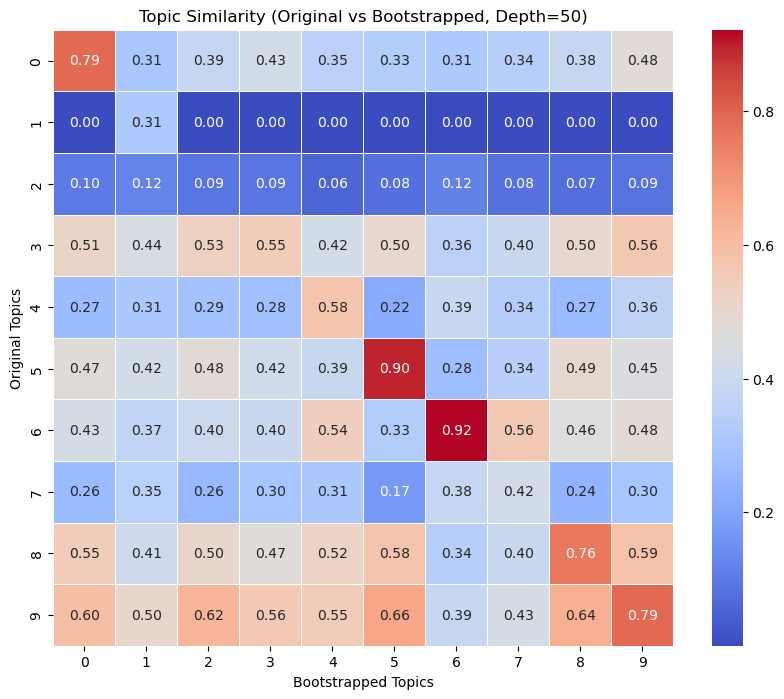


 Running LDA at sampling depth 100...

 Top words per topic (Depth=100):
Topic 0: know edu like don just games year team game think
Topic 1: work does chris read deletion version people use file ax
Topic 2: sorry better mail don got ve list just use good
Topic 3: ll like point just agree think gun com people test
Topic 4: problem use program does window just don like know thanks
Topic 5: don true does life think believe said say people god
Topic 6: monitor does problem need pc dos use windows card drive
Topic 7: make sure like let does mail don edu thanks know
Topic 8: does space time think bike don know like car just
Topic 9: chip people time make use does government don like key


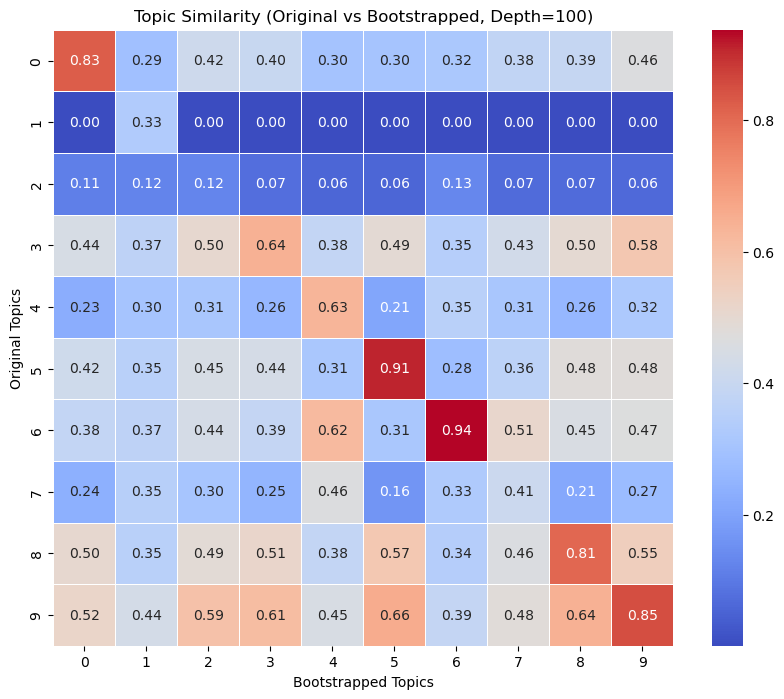


 Running LDA at sampling depth 200...

 Top words per topic (Depth=200):
Topic 0: play season ll like just year games team think game
Topic 1: try read version deletion does work chris use file ax
Topic 2: people sorry like case list don ve good just use
Topic 3: right probably agree ll got people com think just test
Topic 4: edu use does program don window like just know thanks
Topic 5: life true said jesus believe think don say god people
Topic 6: video software dos pc need problem use card windows drive
Topic 7: info address don like email edu mail does know thanks
Topic 8: new good space bike think don know like just car
Topic 9: time good people think use make government like don key


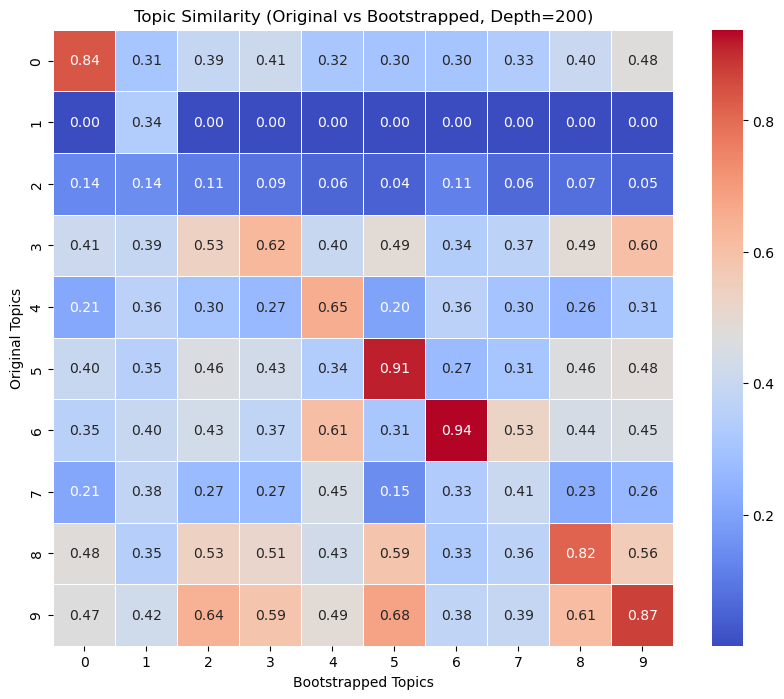


 Running LDA at sampling depth 500...

 Top words per topic (Depth=500):
Topic 0: season players play like just games year think team game
Topic 1: chris deletion does work 11 version use try file ax
Topic 2: answer like case sorry don use ve just good list
Topic 3: got point people gun agree just probably think com test
Topic 4: file help files windows don window like know just thanks
Topic 5: just know life said believe think don say god people
Topic 6: does video software pc need dos use windows card drive
Topic 7: sure new don email like edu mail does thanks know
Topic 8: time new think bike space know don like just car
Topic 9: good time think people make like use don government key


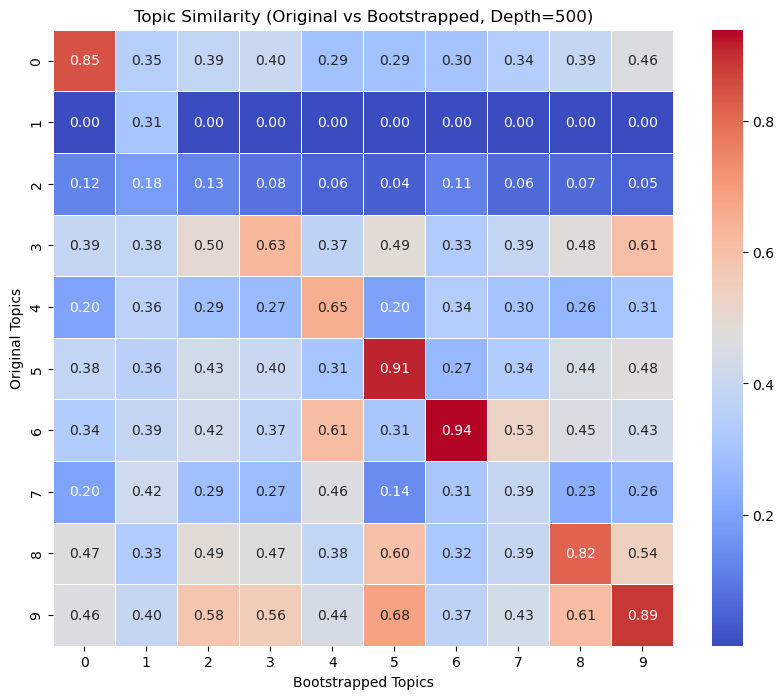

In [17]:

# run LDA on each depth
sampling_depths = [50, 100, 200, 500]
num_topics = 10

for depth in sampling_depths:
    print(f"\n Running LDA at sampling depth {depth}...")

    # resample and revectorize
    resampled_docs = resample_documents(word_counts, depth=depth)
    resampled_counts = vectorizer.transform(resampled_docs)

    # run LDA on bootstrapped data
    lda_bootstrap = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_bootstrap.fit(resampled_counts)
    bootstrap_topic_distributions = lda_bootstrap.components_ / lda_bootstrap.components_.sum(axis=1, keepdims=True)

    # top words per topic
    print(f"\n Top words per topic (Depth={depth}):")
    for topic_idx, topic in enumerate(lda_bootstrap.components_):
        top_words = [vocab[i] for i in topic.argsort()[-10:]]  # Get top 10 words
        print(f"Topic {topic_idx}: {' '.join(top_words)}")

    # compute cosine similarity between topics
    similarity_matrix = cosine_similarity(original_topic_distributions, bootstrap_topic_distributions)

    # plot heat map chart
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
    )

    plt.title(f"Topic Similarity (Original vs Bootstrapped, Depth={depth})")
    plt.xlabel("Bootstrapped Topics")
    plt.ylabel("Original Topics")
    plt.show()

Try training on JUST the training set vs ground truth - see how boostrapping affects actual classification
Similar to body sites, compare how no bootstrapping maps to ground truth vs each sampling depth

DFU Datasets 